In [1]:
from PyTsetlinMachineCUDA.tm import MultiClassTsetlinMachine
import PyTsetlinMachineCUDA.tm
import pyTsetlinMachine
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.signal import spectrogram
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import random
from scipy.ndimage import zoom
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
import json

In [ ]:
# Path to NASA spectrogram files
NASA_spectrogram_root_folder = r"../data/NASA"

# Stores the result in here
json_file = 'TM_NASA_Binary.json'

In [ ]:
labels = [1975, 701, 6071] # Train lable index of failure

# Names of NASA training files
file_names = [
    "1_channel_4.mat",
    "2_channel_0.mat",
    "3_channel_2.mat"
]

file_paths = [os.path.join(NASA_spectrogram_root_folder, file_name_) for file_name_ in file_names]

labels_test = [1616] # Benchmark lable index of failure

# Names of NASA benchmark files
file_names_test = [
    "1_channel_6.mat",
]

file_paths_test = [os.path.join(NASA_spectrogram_root_folder, file_name_) for file_name_ in file_names_test]

In [2]:
def load_mat_spectrogram(mat_file_path, num_bits, std_num=3):
    """
    Load a spectrogram and its timestamps from a MATLAB file, process the spectrogram by standardizing and normalizing it,
    and encode it into multiple binary images based on a specified number of bits.

    Parameters:
    mat_file_path (str): Path to the MATLAB file containing the spectrogram and timestamps.
    num_bits (int): Number of bits to encode the normalized values into binary images.
    std_num (int): Number of standard deviations to use for clipping during standardization.

    Returns:
    tuple: A tuple containing:
           - bit_images_dict (dict): A dictionary of binary images, where each key 'bit_x' corresponds to an encoded image.
           - timestamps (np.array): An array of timestamps associated with each spectrogram column.
    """
    # Load the spectrogram and timestamps from the specified .mat file.
    mat_data = scipy.io.loadmat(mat_file_path)
    spectrogram = mat_data['spectrogram']
    timestamps = mat_data['timestamps'][0]

    # Log the original shape of the spectrogram for debugging.
    print("Spectrogram shape before processing:", spectrogram.shape)

    # Optionally remove mirrored part if necessary (not implemented, just noted for possible future use).
    print("Spectrogram shape after removing mirrored part:", spectrogram.shape)

    # Reduce the resolution of the spectrogram (downsampling in time dimension).
    spectrogram = zoom(spectrogram, (1/20, 1), order=0)

    # Standardize the spectrogram by clipping extreme values based on standard deviation.
    avg_y = np.mean(spectrogram)
    std_y = np.std(spectrogram)
    clean_y = np.clip(spectrogram, avg_y - std_num * std_y, avg_y + std_num * std_y)

    # Normalize the cleaned spectrogram to the range [0, 1].
    clean_y_min = np.min(clean_y)
    clean_y_max = np.max(clean_y)
    norm_y = (clean_y - clean_y_min) / (clean_y_max - clean_y_min)

    # Initialize a dictionary to store the encoded bit images.
    bit_images_dict = {}
    # Determine thresholds for quantizing the normalized spectrogram into bit images.
    num_ranges = 2 ** num_bits
    thresholds = np.linspace(0, 1, num_ranges + 1)

    # Encode the normalized spectrogram into binary bit images using the calculated thresholds.
    for b in range(num_bits):
        bit_image = np.zeros_like(norm_y, dtype=np.uint8)
        for r in range(num_ranges):
            lower_bound = thresholds[r]
            upper_bound = thresholds[r + 1]
            mask = (norm_y >= lower_bound) & (norm_y < upper_bound)
            bit_value = (r >> b) & 1
            bit_image[mask] = bit_value
        bit_images_dict[f'bit_{b + 1}'] = bit_image

    return bit_images_dict, timestamps


In [3]:
def load_process_join(bit_image_dict, bits):
    """
    Aggregate bit image data from a dictionary containing bit images, stacking them vertically to form a single array.

    Parameters:
    bit_image_dict (dict): Dictionary where keys are 'bit_x' and values are corresponding bit images.
    bits (int): Number of bits or slices to process from the dictionary.

    Returns:
    np.array: A vertically stacked array of selected bit images.
    """
    # Initialize a list to store the processed kernels (bit images).
    averaged_kernels = []

    # Iterate over each bit image and append to the list.
    for bit in range(1, bits + 1):
        kernel = bit_image_dict[f'bit_{bit}']
        averaged_kernels.append(kernel)
    
    # Convert the list of kernels to a numpy array and stack them vertically.
    averaged_kernels = np.array(averaged_kernels)
    averaged_kernels = np.vstack(averaged_kernels)
    return averaged_kernels


In [4]:
def prepros(spectrogram, k_width):
    """
    Reshape a spectrogram into overlapping windows of specified width.

    Parameters:
    spectrogram (np.array): The spectrogram data to reshape.
    k_width (int): The number of consecutive slices to include in each window.

    Returns:
    np.array: An array of windows, where each window is a segment of the original spectrogram.
    """
    y_axis = spectrogram.shape[1]
    num_slices = spectrogram.shape[0]

    # Ensure there are enough slices to form at least one window of specified width
    if num_slices < k_width:
        raise ValueError("Not enough slices to form a single window of size k_width")

    # Calculate the number of windows that can be created from the spectrogram
    num_windows = num_slices - k_width + 1

    # Initialize an empty array to store the windows
    reshaped_data = np.empty((num_windows, k_width, y_axis))

    # Create windows using a sliding window approach
    for i in range(num_windows):
        reshaped_data[i] = spectrogram[i:i + k_width]

    return reshaped_data


In [5]:
def process_spectrograms(labels, file_paths, bits, k_width):
    """
    Process spectrograms by loading them, converting to bit image format, and reshaping based on a window width (k_width).
    This function prepares the spectrograms for machine learning models, particularly those requiring input data in sequential format.

    Parameters:
    labels (list): A list of labels corresponding to each spectrogram file.
    file_paths (list): A list of paths to the spectrogram files.
    bits (int): Number of bits used to represent each pixel in the bit image format.
    k_width (int): The number of consecutive slices to include in each window of the output array.

    Returns:
    tuple: A tuple containing two numpy arrays:
           - x_data: Array of reshaped spectrogram data for model input.
           - y_data: Array of labels corresponding to each window of spectrogram data.
    """
    x_data = []
    y_data = []

    # Process each file and label pair.
    for label, path in zip(labels, file_paths):
        # Load the spectrogram and its bit images, then aggregate them.
        bit_image_dict, time_hours = load_mat_spectrogram(path, bits)
        spectrogram = load_process_join(bit_image_dict, bits)
        y = np.zeros(len(time_hours), dtype=np.int32)
        
        # Assign labels based on the specified change point.
        for i in range(len(time_hours)):
            y[i] = 0 if i < label else 1
        
        # Transpose the spectrogram if necessary to correct dimensions.
        spectrogram = spectrogram.T  

        # Split data into two classes based on labels.
        num_ones = np.count_nonzero(y)
        num_zeros = len(y) - num_ones
        
        class_0 = np.array(spectrogram[:num_zeros])
        class_1 = np.array(spectrogram[num_zeros:num_zeros + num_ones])

        # Reshape the data for each class.
        class_0 = prepros(class_0, k_width)
        y_class_0 = np.full(class_0.shape[0], 0)

        class_1 = prepros(class_1, k_width)
        y_class_1 = np.full(class_1.shape[0], 1)

        # Append the processed data and labels to the respective lists.
        x_data.append(class_0)
        y_data.append(y_class_0)
        x_data.append(class_1)
        y_data.append(y_class_1)

    # Convert lists to numpy arrays for consistency and to support machine learning operations.
    x_data = np.array(x_data, dtype=object)
    y_data = np.array(y_data, dtype=object)

    return x_data, y_data


In [6]:
# Define parameters for window size, bits and paths for training and testing data
k_width = 5
bits = 3


# Process training data
x_data, y_data = process_spectrograms(labels, file_paths, k_width)
x_data = np.vstack(x_data)
flattened_data = x_data.reshape(-1, x_data.shape[1] * x_data.shape[2])
flattened_array = np.concatenate(y_data)

# Process testing data
x_data_test, y_data_test = process_spectrograms(labels_test, file_paths_test, k_width)
x_data_test = np.vstack(x_data_test)
flattened_data_test = x_data_test.reshape(-1, x_data_test.shape[1] * x_data_test.shape[2])
flattened_array_test = np.concatenate(y_data_test)

# Data now ready for model training/testing

Spectrogram shape before processing: (20480, 2156)
Spectrogram shape after removing mirrored part: (10240, 2156)
spec shape after tranform (2156, 1536)
class 0 shape before prerpos (1975, 1536)
class 1 shape before prerpos (181, 1536)
num_slices 1975
class 0 shape (1971, 5, 1536)
num_slices 181
class 1 shape (177, 5, 1536)
(177,)
(1971,)
Spectrogram shape before processing: (20480, 984)
Spectrogram shape after removing mirrored part: (10240, 984)
spec shape after tranform (984, 1536)
class 0 shape before prerpos (701, 1536)
class 1 shape before prerpos (283, 1536)
num_slices 701
class 0 shape (697, 5, 1536)
num_slices 283
class 1 shape (279, 5, 1536)
(279,)
(697,)
Spectrogram shape before processing: (20480, 6324)
Spectrogram shape after removing mirrored part: (10240, 6324)
spec shape after tranform (6324, 1536)
class 0 shape before prerpos (6071, 1536)
class 1 shape before prerpos (253, 1536)
num_slices 6071
class 0 shape (6067, 5, 1536)
num_slices 253
class 1 shape (249, 5, 1536)
(2

In [7]:
print(flattened_data.shape)
print(flattened_data_test.shape)

(9440, 7680)
(2148, 7680)


Epoch 1 - Test Accuracy: 94.28%, F1 Score: 0.75
Epoch 1 - Unseen Accuracy: 96.65%, F1 Score: 0.95
Epoch 21 - Test Accuracy: 98.52%, F1 Score: 0.95
Epoch 21 - Unseen Accuracy: 94.69%, F1 Score: 0.93
Epoch 41 - Test Accuracy: 98.57%, F1 Score: 0.95
Epoch 41 - Unseen Accuracy: 98.14%, F1 Score: 0.98
Epoch 61 - Test Accuracy: 98.09%, F1 Score: 0.94
Epoch 61 - Unseen Accuracy: 98.65%, F1 Score: 0.98
Epoch 1 - Test Accuracy: 94.28%, F1 Score: 0.75
Epoch 1 - Unseen Accuracy: 96.37%, F1 Score: 0.95
Epoch 21 - Test Accuracy: 98.52%, F1 Score: 0.95
Epoch 21 - Unseen Accuracy: 91.62%, F1 Score: 0.90
Epoch 41 - Test Accuracy: 98.25%, F1 Score: 0.94
Epoch 41 - Unseen Accuracy: 98.51%, F1 Score: 0.98
Epoch 61 - Test Accuracy: 98.09%, F1 Score: 0.94
Epoch 61 - Unseen Accuracy: 98.70%, F1 Score: 0.98
Epoch 1 - Test Accuracy: 94.33%, F1 Score: 0.75
Epoch 1 - Unseen Accuracy: 95.95%, F1 Score: 0.95
Epoch 21 - Test Accuracy: 98.04%, F1 Score: 0.93
Epoch 21 - Unseen Accuracy: 97.67%, F1 Score: 0.97
Epoch 

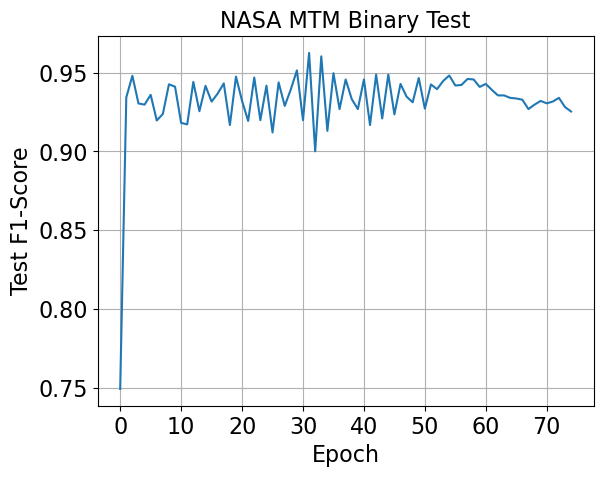

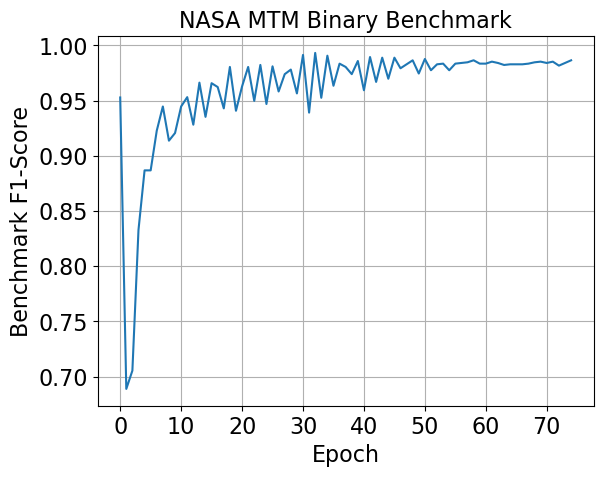

In [8]:
C = flattened_data.shape[1] 
T = np.power((C/0.8377),1/2.2099)
s = 2.534*np.log((C/3.7579))

# Split your combined dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(flattened_data, flattened_array, test_size=0.2)

training_steps = 75
epochs = 1
runs = 1 # Number of runs in total the Tsetlin Machine will do

for i in range(runs):
    tm = MultiClassTsetlinMachine(int(C), T, s) # Init the Tsetlin Machine
    epoch_accuracies = []
    epoch_unseen = []
    epoch_accuracies_f1 = []
    epoch_unseen_f1 = []
    for epoch in range(training_steps):
        # Incrementally fit the Tsetlin Machine on each dataset
        tm.fit(X_train, y_train, epochs=epochs, incremental=True) # Train for epoch
        
        Y_pred = tm.predict(X_test)
        accuracy = accuracy_score(y_test, Y_pred)
        f1 = f1_score(y_test, Y_pred, average='macro')  # Using 'macro' to average scores of each class
        if epoch % 20 == 0:
            print(f'Epoch {epoch+1} - Test Accuracy: {accuracy * 100:.2f}%, F1 Score: {f1:.2f}')
        epoch_accuracies.append(accuracy)
        epoch_accuracies_f1.append(f1)
        a_s = accuracy
        a_s1 = f1
        
        # Prediction and evaluation on unseen data
        Y_pred_unseen = tm.predict(flattened_data_test)
        accuracy_unseen = accuracy_score(flattened_array_test, Y_pred_unseen)
        f1_unseen = f1_score(flattened_array_test, Y_pred_unseen, average='macro')
        if epoch % 20 == 0:
            print(f'Epoch {epoch+1} - Unseen Accuracy: {accuracy_unseen * 100:.2f}%, F1 Score: {f1_unseen:.2f}')
        epoch_unseen.append(accuracy_unseen)
        epoch_unseen_f1.append(f1_unseen)
        a_u = accuracy_unseen
        a_u1 = f1_unseen

        accuracy_data = {
            "epoch_accuracies": epoch_accuracies,
            "epoch_unseen": epoch_unseen
        }

        try:
            with open(json_file, 'r') as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            data = {'training_run': [],}
            with open(json_file, 'w') as file:  
                json.dump(data, file)  

        data['training_run'].append({
            'seendata': a_s,
            'unseendata': a_u,
            'seendata_f1': a_s1,
            'unseendata_f1': a_u1,
        })
        
        with open(json_file, 'w') as f:
            json.dump(data, f, indent=4)

plt.plot(epoch_accuracies_f1)
plt.title('NASA MTM Binary Test',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Test F1-Score',fontsize=16)
#plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.savefig('../plot/TM_NASA_Binary_f1_test.pdf') # Option for saving plot
plt.show()

plt.plot(epoch_unseen_f1)
plt.title('NASA MTM Binary Benchmark',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Benchmark F1-Score',fontsize=16)
#plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.savefig('../plot/TM_NASA_Binary_f1_benchmark.pdf') # Option for saving plot
plt.show()


Confusion Matrix:
[[8728    7]
 [  35  670]]


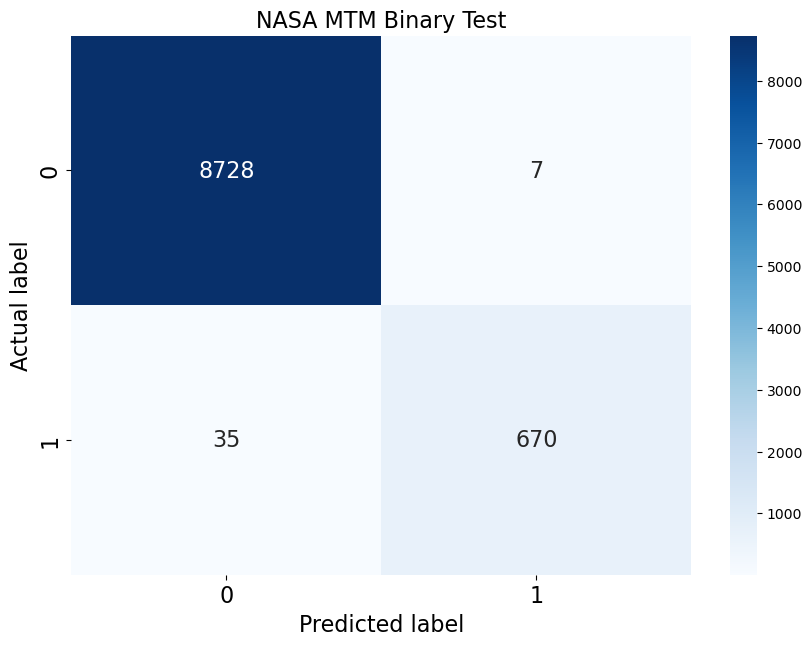

Confusion Matrix:
[[1591   21]
 [   1  535]]


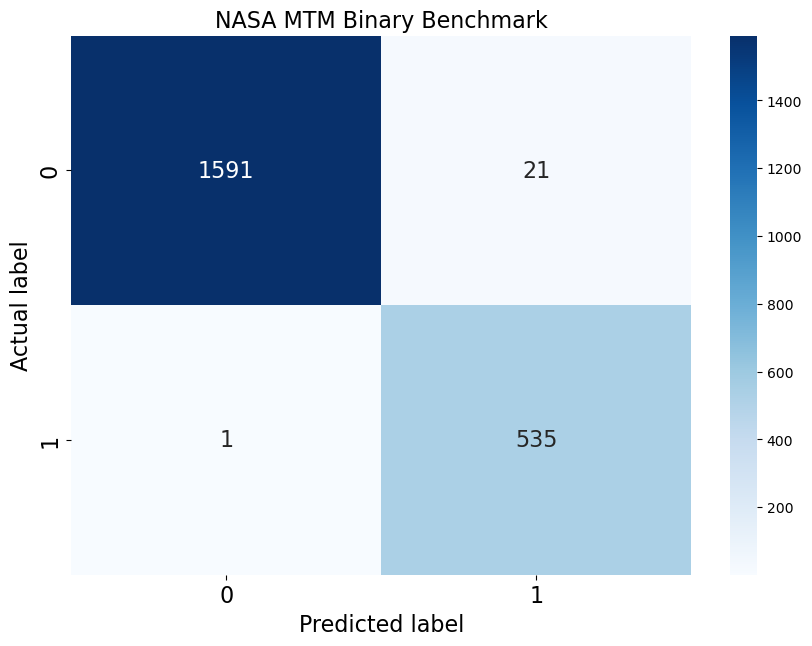

In [9]:
Y_pred = tm.predict(flattened_data)
flattened_array = flattened_array.astype(Y_pred.dtype)
conf_matrix = confusion_matrix(flattened_array, Y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True,
            annot_kws={"size": 16}) 
plt.title('NASA MTM Binary Test', fontsize=16)
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
# plt.savefig('../plot/CM_NASA_Binary_test.pdf') # Option for saving plot
plt.show()


Y_pred = tm.predict(flattened_data_test)
flattened_array_test = flattened_array_test.astype(Y_pred.dtype)
conf_matrix = confusion_matrix(flattened_array_test, Y_pred)
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True,
            annot_kws={"size": 16})  # Increase size here for annotations
plt.title('NASA MTM Binary Benchmark', fontsize=16)  # Increased title font size
plt.ylabel('Actual label', fontsize=16)  # Increased y-axis label font size
plt.xlabel('Predicted label', fontsize=16)  # Increased x-axis label font size
plt.xticks(fontsize=16)  # Increase x-axis tick font size
plt.yticks(fontsize=16)  # Increase y-axis tick font size
# plt.savefig('../plot/CM_NASA_Binary_benchmark.pdf') # Option for saving plot
plt.show()

In [10]:
Y_pred = tm.predict(flattened_data_test)
flattened_array_test = flattened_array_test.astype(Y_pred.dtype)
print(Y_pred[0])
print(flattened_array_test[0])
wrong_guesses = []
for i in range(len(Y_pred)):
    if Y_pred[i] != flattened_array_test[i]:
        wrong_guesses.append(i)

print(wrong_guesses)

0
0
[450, 509, 512, 514, 528, 1530, 1559, 1567, 1577, 1579, 1581, 1587, 1596, 1597, 1598, 1600, 1601, 1605, 1606, 1607, 1609, 1642]


In [11]:
Y_pred = tm.predict(flattened_data_test)
flattened_array_test = flattened_array_test.astype(Y_pred.dtype)
wrong_guesses = [i for i in range(len(Y_pred)) if Y_pred[i] != flattened_array_test[i]]
print(wrong_guesses)

[450, 509, 512, 514, 528, 1530, 1559, 1567, 1577, 1579, 1581, 1587, 1596, 1597, 1598, 1600, 1601, 1605, 1606, 1607, 1609, 1642]


In [12]:
print(C)
print(T)
print(s)

7680
62.08185803616254
19.315451832712153
